In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, chi2, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [2]:

# --- Step 1: Load Dataset ---
try:
    df = pd.read_csv(r"C:\Users\USER\python\heart_data_clean.csv")
    print(" Data loaded successfully for Feature Selection.")
except FileNotFoundError:
    print("'heart_data_clean.csv' not found")
    raise

print(f"Data shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
df.head()


 Data loaded successfully for Feature Selection.
Data shape: (303, 14)
Columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [3]:

# --- Step 2: Split into Features and Target ---
X = df.drop(columns=["target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Features shape:", X.shape)
print("Target distribution:\n", y.value_counts())


Features shape: (303, 13)
Target distribution:
 target
0    164
1    139
Name: count, dtype: int64


Top 15 features by Random Forest:
 ['thalach', 'cp', 'thal', 'ca', 'age', 'oldpeak', 'chol', 'trestbps', 'exang', 'slope', 'sex', 'restecg', 'fbs']


C:\Users\USER\AppData\Local\Temp\ipykernel_68168\805984477.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.head(15).values, y=importances.head(15).index, palette="viridis")


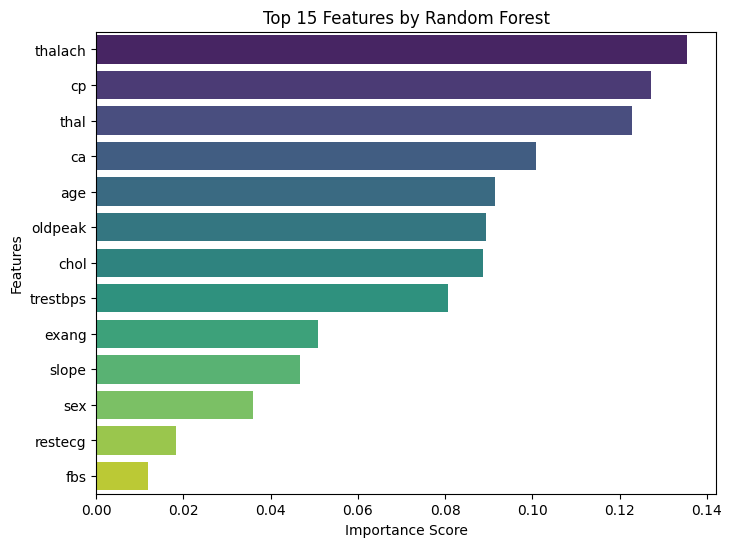

In [4]:

# --- Step 3: Random Forest Feature Importance ---
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

rf_features = list(
    pd.Series(rf.feature_importances_, index=X.columns)
    .sort_values(ascending=False)
    .head(15)
    .index
)

print("Top 15 features by Random Forest:\n", rf_features)

# Plot
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x=importances.head(15).values, y=importances.head(15).index, palette="viridis")
plt.title("Top 15 Features by Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


In [5]:

# --- Step 4: Recursive Feature Elimination (RFE) ---
log_reg = LogisticRegression(max_iter=500, solver="liblinear")
rfe = RFE(log_reg, n_features_to_select=10)
rfe.fit(X_train, y_train)

selected_rfe = list(X.columns[rfe.support_])
print("Top 10 features by RFE:\n", selected_rfe)


Top 10 features by RFE:
 ['sex', 'cp', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


In [6]:

# --- Step 5: Chi-Square Feature Selection ---
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

chi2_selector = SelectKBest(score_func=chi2, k=10)
chi2_selector.fit(X_train_scaled, y_train)

selected_chi2 = list(X_train.columns[chi2_selector.get_support()])
print(" Top 10 features by Chi-Square:\n", selected_chi2)


 Top 10 features by Chi-Square:
 ['age', 'sex', 'cp', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


In [7]:

# --- Step 6: Final Feature Selection (Intersection) ---
final_features = list(set(selected_rfe) & set(selected_chi2))
print("Final Selected Features for Modeling:")
print(final_features)

X_selected = X[final_features]
final_df = pd.concat([X_selected, y], axis=1)
final_df.head()


Final Selected Features for Modeling:
['ca', 'exang', 'cp', 'restecg', 'thalach', 'oldpeak', 'thal', 'sex', 'slope']


,ca,exang,cp,restecg,thalach,oldpeak,thal,sex,slope,target
0,0.0,0.0,1.0,2.0,150.0,2.3,6.0,1.0,3.0,0
1,3.0,1.0,4.0,2.0,108.0,1.5,3.0,1.0,2.0,1
2,2.0,1.0,4.0,2.0,129.0,2.6,7.0,1.0,2.0,1
3,0.0,0.0,3.0,0.0,187.0,3.5,3.0,1.0,3.0,0
4,0.0,0.0,2.0,2.0,172.0,1.4,3.0,0.0,1.0,0


C:\Users\USER\AppData\Local\Temp\ipykernel_68168\2444730314.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=final_importances.values, y=final_importances.index, palette="plasma")


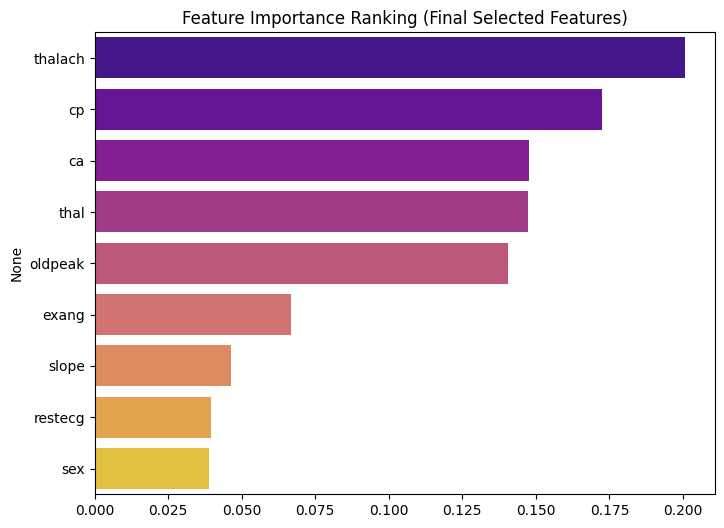

In [8]:

# --- Step 7: Train Random Forest on Final Selected Features ---
rf_final = RandomForestClassifier(random_state=42)
rf_final.fit(X_selected, y)

final_importances = pd.Series(
    rf_final.feature_importances_, index=final_features
).sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=final_importances.values, y=final_importances.index, palette="plasma")
plt.title("Feature Importance Ranking (Final Selected Features)")
plt.show()


In [9]:

# --- Step 8: Save Final Reduced Dataset ---
output_file = r"C:\Users\USER\python\heart_final_selected.csv"
final_df.to_csv(output_file, index=False)
print("Final dataset shape:", final_df.shape)


Final dataset shape: (303, 10)
